# Creating an LDA model of wine descriptions,
# how many are there "really"?

Sure, there's 130,000 reviews of wines from around the world expounding their diverse tastes and characters, but how many "really" exist?  How many supergroups of wines that are essentially similar can be identified, and what's a representative example of each?  As someone who likes both red AND white wines (let's be honest; rose's just half and half) I feel uniquely qualified to answer this.  Let's perform a gid search of a large number of LDA models and find that with the best coherence & perplexity scores!  And then we'll visualise the countries of origin and the keywords that most characterise the qualities of these supergroups.

In [1]:
import gensim
import re
import random
import pyLDAvis

import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim as gensimvis

from gensim.models.ldamulticore import LdaModel

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.stem import SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

%matplotlib inline

In [2]:
wine_df = pd.read_csv("./data/wine-reviews/winemag-data-130k-v2.csv")
wine_df['desc_len'] = wine_df['description'].apply(len)

## 1.  Data exploration (I'm not doing much!)

In [3]:
list(wine_df)

['Unnamed: 0',
 'country',
 'description',
 'designation',
 'points',
 'price',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'taster_twitter_handle',
 'title',
 'variety',
 'winery',
 'desc_len']

In [4]:
wine_df[["description", "country", "taster_name", "desc_len"]].head()

,description,country,taster_name,desc_len
0,"Aromas include tropical fruit, broom, brimston...",Italy,Kerin O’Keefe,172
1,"This is ripe and fruity, a wine that is smooth...",Portugal,Roger Voss,227
2,"Tart and snappy, the flavors of lime flesh and...",US,Paul Gregutt,186
3,"Pineapple rind, lemon pith and orange blossom ...",US,Alexander Peartree,199
4,"Much like the regular bottling from 2012, this...",US,Paul Gregutt,249


# 2.  Data Preparation

In [5]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

In [6]:
# NB;  This step could be improved through first filtering to words that are pronouns.
wine_df['tokens'] = wine_df['description'].apply(preprocess_desc)

In [7]:
wine_df[["description", "country", "taster_name", "desc_len", "tokens"]].head()

,description,country,taster_name,desc_len,tokens
0,"Aromas include tropical fruit, broom, brimston...",Italy,Kerin O’Keefe,172,"[aroma, includ, tropic, fruit, broom, brimston..."
1,"This is ripe and fruity, a wine that is smooth...",Portugal,Roger Voss,227,"[ripe, fruiti, wine, smooth, structur, firm, t..."
2,"Tart and snappy, the flavors of lime flesh and...",US,Paul Gregutt,186,"[tart, snappi, flavor, lime, flesh, rind, domi..."
3,"Pineapple rind, lemon pith and orange blossom ...",US,Alexander Peartree,199,"[pineappl, rind, lemon, pith, orang, blossom, ..."
4,"Much like the regular bottling from 2012, this...",US,Paul Gregutt,249,"[like, regular, bottl, come, rough, tannic, ru..."


## 3. Create TF-IDF representation

In [8]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(wine_df['tokens'])

In [9]:
# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [10]:
# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in wine_df['tokens']]

In [11]:
# From that create the TF-IDF model
tfidf = gensim.models.TfidfModel(bow_corpus)
wine_df['corpus_tfidf'] = tfidf[bow_corpus]

In [12]:
wine_df['corpus_tfidf'].head()

0    [(0, 0.07160155708244689), (1, 0.1877195732633...
1    [(0, 0.09083746481579533), (10, 0.063390218940...
2    [(0, 0.07030752616398264), (33, 0.131602894540...
3    [(3, 0.06051027977427229), (16, 0.064085312284...
4    [(65, 0.129161659467362), (66, 0.2234435211947...
Name: corpus_tfidf, dtype: object

## 4.  Create LDA models (try a few!)
Train-test split only, because I'm not iteratively improving anything here (it's for coursework dammit, no one cares!)

In [52]:
random.seed(7)
trainset, testset = train_test_split(wine_df, test_size=0.15)

In [53]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()

for num_topics in range(3, 51):

    # Fit the lda model, with 10 topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("tested_lda_stats.csv")    

tried 3 topics perplexity = -8.134159893306359 coherence = -2.0683865045577012
tried 4 topics perplexity = -8.269554133873681 coherence = -2.0932255052976028
tried 5 topics perplexity = -8.45754303160014 coherence = -2.146341883234046
tried 6 topics perplexity = -8.621868042818727 coherence = -4.049721776884863
tried 7 topics perplexity = -8.781977439839023 coherence = -2.1398669581777616
tried 8 topics perplexity = -8.856188891809948 coherence = -7.743528954791789
tried 9 topics perplexity = -9.016759790814767 coherence = -4.8888176384461985
tried 10 topics perplexity = -9.17627224938949 coherence = -5.360438528111849
tried 11 topics perplexity = -9.425007163344729 coherence = -5.035231079839597
tried 12 topics perplexity = -9.725160330246982 coherence = -5.249061359865915
tried 13 topics perplexity = -9.909611391295044 coherence = -10.670886791988334
tried 14 topics perplexity = -10.102366778649392 coherence = -8.172530204728018
tried 15 topics perplexity = -10.289885560148866 cohere

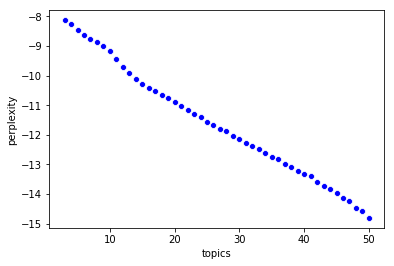

In [54]:
# plot the results
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

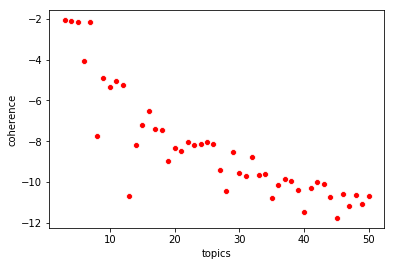

In [55]:
# plot the results
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 5.  Create the "Best" Model!

So what's the "best" model according to my two somewhat-arbitrary metrics?  First off it's worth noting that the metrics follow a consistent downward trend.  We are looking for a low perplexity score and a high coherence score.  Our other constraint is that I, personally, don't believe there can be more than 15 "true" varieties of wines!

This last constraint is both a cheat that undermines the entire idea, and absolutely neccessary.  Unless you've got a very weirdly well-divided, well fleshed-out dataset of fairly long documents there's not going to be a "true" underlying topic model.  There'll be overlap in topic, and worse the topics can be fractal in nature, sub-dividing and making it difficult to know where to call it quits.

Within this constraint, models with 9, 10, 11 or 12 topics display a consistently good coherence score suggesting a some persistence in discovered topics.  Over this range we also see something of a step-change in perplexity, implying a qualitative improvement over having smaller numbers of topics.

I choose 11 topics - the value comes on the down-side of that possible step-change in perplexity, and has a locally better coherence score.

In [ ]:
# Fit the final lda model to all data
lda_model_tfidf = LdaModel(wine_df['corpus_tfidf'],
                           num_topics=11,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(wine_df['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=wine_df['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

In [ ]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

### So how did we do?
Well;  looking at the words involved there are some valid-looking clusters there with some very apparently citrusy wines separated from aged, oakey wines!  This is a success!  There's a sweet wine cluster too with cherries, blackberries, "soft" and "sweet" flavours mentioned.  There's also annoyingly a weird topic that may have more to do with ancilliary descriptions of how wines are constructed - topic 1, describing stainless steel apperatus, and words like "vineyard" and "ferment".

An obvious solution;  Simply ignore that topic during processing/assignment to clusters/visualisation!  Topic 0 may also be ancilliary details, mentioning "cover", "salmon", "rest" and "extra" - words that imply a link to serving suggestions.

This is ultimately a useful lesson in the divergence of the latent topics of the corpus (on wine TASTING) from the topics we were seeking (on wine FLAVOUR).  A really useful way to examine the fit of what we've created is to utilise pyLDAvis, which uses PCA to do exactly what it says on the tin!

And as it happens it supports the earlier conclusion;  in the first two principal components (and ignoring the part where it mucked up the topic indexes) the topics related to fermentation and serving suggestions appear well separated from the topics related to flavour.  Additionally, topic 9 is out of the way too, it talks of "nose", "gravel", and then a list of herbs that frankly sound like they'd go well with beef.  This decision, that these three topics are not like the rest and not relevant to our aims, is bourne out by the proportion of the corpus assigned to them.  Each of the three rogue topics contains 2-5 % of documents (roughly eyeballed), whereas the "valid" topics contain closer to 10 % each typically.

### Final Conclusion
The best-fit (low topic number) model has 11 topics.  Of those, three topics (index 0, 1 and 9) appear to be invalid, representing aspects of the descriptions less relevant to flavour.  This leaves 8 "valid" topics to be presented.

In [22]:
vis_data = gensimvis.prepare(lda_model_tfidf, wine_df['corpus_tfidf'], dictionary)

KeyboardInterrupt: 

In [ ]:
pyLDAvis.display(vis_data)

In [17]:
lda_model_tfidf.save("./models/lda_model_tfidf_11.model")

## 6.  Save the results (and switch to R!)
And for coursework reasons the visualisations of my brilliant work on wine must be presented using R.  I'll do some formatting and save the output topic models etc in some form R will like.

In [13]:
lda_model_tfidf = LdaModel.load("./models/lda_model_tfidf_11.model")

In [14]:
doc_topics = [ [x[1] for x in doc] for doc in lda_model_tfidf.get_document_topics(wine_df['corpus_tfidf']) ]

In [15]:
doc_topics[0:5]

[[0.018757854,
  0.018757995,
  0.018759832,
  0.018758893,
  0.55141985,
  0.1868327,
  0.018759614,
  0.01876138,
  0.018761182,
  0.1116721,
  0.018758567],
 [0.020118373,
  0.10271136,
  0.02012037,
  0.020118715,
  0.02011846,
  0.020118464,
  0.02012011,
  0.14763111,
  0.020118715,
  0.020117633,
  0.58870673],
 [0.019674119,
  0.35602343,
  0.01967457,
  0.46689016,
  0.019680006,
  0.019674566,
  0.01967493,
  0.019682227,
  0.019675296,
  0.019674884,
  0.01967583],
 [0.3271295,
  0.017177885,
  0.01717926,
  0.017182808,
  0.5182525,
  0.017178705,
  0.017178932,
  0.017179705,
  0.017180199,
  0.017180324,
  0.01718022],
 [0.017358111,
  0.017358176,
  0.14325555,
  0.017358864,
  0.017359735,
  0.084661685,
  0.37818086,
  0.2723894,
  0.017359892,
  0.017359335,
  0.01735843]]

In [16]:
doc_topic_df = pd.DataFrame(doc_topics)
doc_topic_df['title'] = wine_df['title']

In [17]:
doc_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,10,title
0,0.018758,0.018758,0.018760,0.018759,0.551420,0.186833,0.018760,0.018761,0.018761,0.111672,0.018759,Nicosia 2013 Vulkà Bianco (Etna)
1,0.020118,0.102711,0.020120,0.020119,0.020118,0.020118,0.020120,0.147631,0.020119,0.020118,0.588707,Quinta dos Avidagos 2011 Avidagos Red (Douro)
2,0.019674,0.356023,0.019675,0.466890,0.019680,0.019675,0.019675,0.019682,0.019675,0.019675,0.019676,Rainstorm 2013 Pinot Gris (Willamette Valley)
3,0.327130,0.017178,0.017179,0.017183,0.518252,0.017179,0.017179,0.017180,0.017180,0.017180,0.017180,St. Julian 2013 Reserve Late Harvest Riesling ...
4,0.017358,0.017358,0.143256,0.017359,0.017360,0.084662,0.378181,0.272389,0.017360,0.017359,0.017358,Sweet Cheeks 2012 Vintner's Reserve Wild Child...


In [18]:
results = wine_df.merge(doc_topic_df, on="title")

In [21]:
results[['description', 'tokens']].head()

,description,tokens
0,"Aromas include tropical fruit, broom, brimston...","[aroma, includ, tropic, fruit, broom, brimston..."
1,"This is ripe and fruity, a wine that is smooth...","[ripe, fruiti, wine, smooth, structur, firm, t..."
2,"Tart and snappy, the flavors of lime flesh and...","[tart, snappi, flavor, lime, flesh, rind, domi..."
3,"Pineapple rind, lemon pith and orange blossom ...","[pineappl, rind, lemon, pith, orang, blossom, ..."
4,"Much like the regular bottling from 2012, this...","[like, regular, bottl, come, rough, tannic, ru..."


In [20]:
results.to_csv("wine_reviews_with_topic_distributions.csv", index=False)